<a href="https://colab.research.google.com/github/1eetnals/Mary-s-Hospital-AI-center/blob/main/seg_sss_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

     |████████████████████████████████| 635 kB 5.3 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil
import tempfile
import nibabel as nib

import matplotlib.pyplot as plt
import numpy as np
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.transforms import (
    Activations,
    AsChannelFirstd,
    AsDiscrete,        
    AddChanneld,
    CenterSpatialCropd,
    Compose,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    NormalizeIntensity,
    Orientationd,
    RandFlipd,
    RandAxisFlipd,
    Affine,
    GaussianSmoothd,
    RandScaleIntensityd,
    ResizeWithPadOrCropd,
    RandShiftIntensityd,
    RandSpatialCropd,
    RandAffined,
    RandGaussianNoised,
    RandGaussianSmoothd,
    RandRotate90d,
    RandWeightedCrop,
    Spacingd,
    ToTensord,
)
from monai.utils import set_determinism
from monai.data import CacheDataset, DataLoader, Dataset
from monai.utils import first
from monai.inferers import sliding_window_inference
from monai.metrics import compute_meandice

import torch

print_config()

MONAI version: 0.7.dev2130
Numpy version: 1.19.5
Pytorch version: 1.9.0+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: c3dcf6854e456071443c7709336cae556eb712ff

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.16.2
Pillow version: 7.1.2
Tensorboard version: 2.5.0
gdown version: 3.6.4
TorchVision version: 0.10.0+cu102
tqdm version: 4.61.2
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.1.5
einops version: 0.3.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [ ]:
path0 = '/content/drive/MyDrive/sss_verio3'
fname0 = os.listdir(path0)
print(len(fname0))
fname0

In [ ]:
train_ind = np.arange(0,25)
train_files = [
    {
        "image1": os.path.join(path0, fname0[idx],"3D_SWI_M.nii.gz"),
        "image2": os.path.join(path0, fname0[idx],"3D_SWI_M_UP.nii.gz"),
        "label": os.path.join(path0, fname0[idx],"vein3_v20190728.nii.gz"),
    }
    for idx in train_ind
]
train_files

In [ ]:
val_ind = np.arange(25,30)
val_files = [
    {
        "image1": os.path.join(path0, fname0[idx],"3D_SWI_M.nii.gz"),
        "image2": os.path.join(path0, fname0[idx],"3D_SWI_M_UP.nii.gz"),
        "label": os.path.join(path0, fname0[idx],"vein3_v20190728.nii.gz"),
    }
    for idx in val_ind
]
val_files

In [ ]:
class ConvertToMultiChannel(MapTransform):
    """
    Convert labels to multi channels:

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            result.append(d[key].astype(np.int8) > 0)
#            result.append(d[key].astype(np.int8) == 2)
#            result.append(d[key].astype(np.int8) == 3)
#            result.append(d[key].astype(np.int8) == 4)

            d[key] = np.stack(result, axis=0).astype(np.float32)
        return d

In [ ]:

train_transforms = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image1","image2", "label"]),
        ConvertToMultiChannel(keys="label"),
        AddChanneld(keys=["image1"]),
        AddChanneld(keys=["image2"]),
        
        Spacingd(
            keys=["image1", "image2", "label"],
            pixdim=(1., 1., 1.),
            mode=("bilinear", "bilinear","nearest"),
        ),
        
        RandAffined( 
            keys=["image1","image2","label"],
            prob=0.75,                       
            translate_range=((-15,15),(-15,15),(-15,15)),         
            rotate_range=(.15, .15, .15),                          
            scale_range=(.15,.15,.15),
            padding_mode='zeros',
            mode = ("bilinear","bilinear","nearest")),
   
        
        Orientationd(keys=["image1", "image2","label"], axcodes="IPR"),
       # RandSpatialCropd(
       #     keys=["image1", "image2","label"], roi_size=[80, 80, 80], random_size=False
       # ),        

        ResizeWithPadOrCropd(keys=["image1","image2","label"],spatial_size=(256,256,48)),

        #CenterSpatialCropd(keys=["image1","image2", "label"], roi_size=[96, 96, 96]),
        #RandFlipd(keys=["image", "label"], prob=1, spatial_axis=[0,1,2]),
#        RandAxisFlipd(keys=["image1","image2","label"],prob=0.5,),
#        RandRotate90d(keys=["image1","image2","label"],prob=0.5,spatial_axes=(0,1)),
        
        NormalizeIntensityd(keys=["image1","image2"], nonzero=True, channel_wise=True),
        
        RandGaussianNoised(keys=["image1"],std=0.125,prob=0.5),
        RandGaussianNoised(keys=["image2"],std=0.125,prob=0.5),
        RandShiftIntensityd(keys=["image1"], offsets=(-.05,.05), prob=.75),
        RandShiftIntensityd(keys=["image2"], offsets=(-.05,.05), prob=.75),
        RandScaleIntensityd(keys=["image1"], factors=(-.75,1.25), prob=.75),
        RandScaleIntensityd(keys=["image2"], factors=(-.75,1.25), prob=.75),
        RandGaussianSmoothd(keys=["image1","image2"],sigma_x=(0.25,.5),sigma_y=(0.25,.5),sigma_z=(0.25,.5),prob=0.5),

        ToTensord(keys=["image1","image2","label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image1","image2", "label"]),
        ConvertToMultiChannel(keys="label"),
        AddChanneld(keys=["image1"]),
        AddChanneld(keys=["image2"]),     
        Spacingd(
            keys=["image1", "image2", "label"],
            pixdim=(1., 1., 1.),
            mode=("bilinear", "bilinear","nearest"),
        ),     
        Orientationd(keys=["image1","image2", "label"], axcodes="IPR"),
        ResizeWithPadOrCropd(keys=["image1","image2","label"],spatial_size=(256,256,48)),
        NormalizeIntensityd(keys=["image1","image2"], nonzero=True, channel_wise=True),
   #     GaussianSmoothd(keys=["image1","image2"],sigma=0.5),
        ToTensord(keys=["image1", "image2","label"]),
    ]
)

image shape: torch.Size([256, 256, 48]), label shape: torch.Size([256, 256, 48])


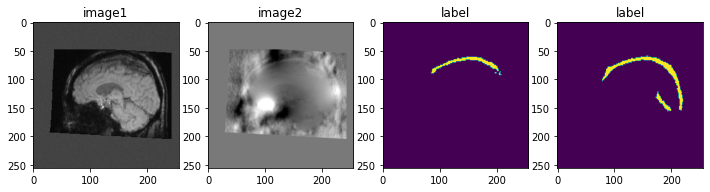

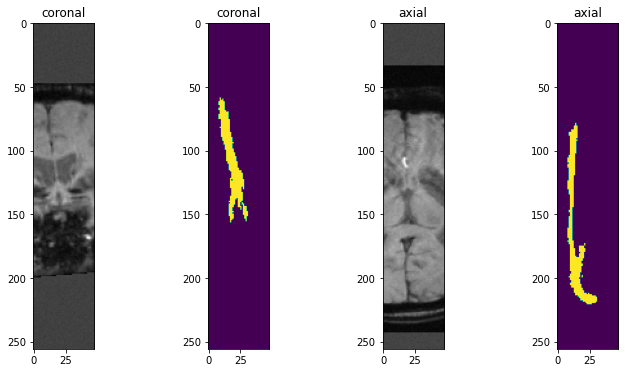

In [ ]:
check_ds = Dataset(data=train_files, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
#image1, image2, label = ((check_data["image2"])[0][0], check_data["image1"][0][0],check_data["label"][0][0])

image1, image2, label = ((check_data["image1"])[0][0], check_data["image2"][0][0],check_data["label"][0][0])
print(f"image shape: {image1.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
zz = np.argmax(np.sum(np.sum(np.array(label),axis=1),axis=0))
plt.figure("check", (12, 6))
plt.subplot(1, 4, 1)
plt.title("image1")
plt.imshow(image1[:,:,zz], cmap="gray")
plt.subplot(1, 4, 2)
plt.title("image2")
plt.imshow(image2[:,:,zz], cmap="gray")
plt.subplot(1, 4, 3)
plt.title("label")
plt.imshow(label[:,:,zz])
plt.subplot(1, 4, 4)
plt.title("label")
plt.imshow(torch.amax(label,axis=2))
plt.show()

plt.figure("check", (12, 6))
plt.subplot(1, 4, 1)
plt.title("coronal")
plt.imshow(image1[:,128,:], cmap="gray")
plt.subplot(1, 4, 2)
plt.title("coronal")
plt.imshow(torch.amax(label,axis=1))
plt.subplot(1, 4, 3)
plt.title("axial")
plt.imshow(image1[128,:,:], cmap="gray")
plt.subplot(1, 4, 4)
plt.title("axial")
plt.imshow(torch.amax(label,axis=0))
plt.show()


image shape: torch.Size([256, 256, 48]), label shape: torch.Size([256, 256, 48])


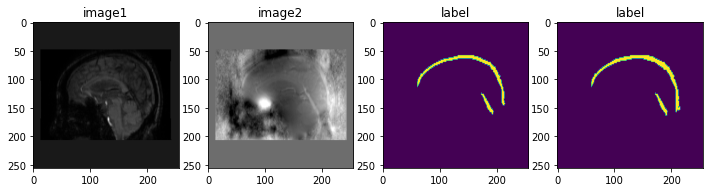

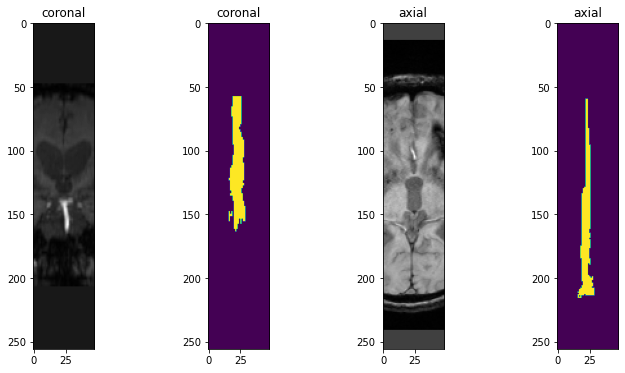

In [ ]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
#image1, image2, label = ((check_data["image2"])[0][0], check_data["image1"][0][0],check_data["label"][0][0])

image1, image2, label = ((check_data["image1"])[0][0], check_data["image2"][0][0],check_data["label"][0][0])
print(f"image shape: {image1.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
zz = np.argmax(np.sum(np.sum(np.array(label),axis=1),axis=0))
plt.figure("check", (12, 6))
plt.subplot(1, 4, 1)
plt.title("image1")
plt.imshow(image1[:,:,zz], cmap="gray")
plt.subplot(1, 4, 2)
plt.title("image2")
plt.imshow(image2[:,:,zz], cmap="gray")
plt.subplot(1, 4, 3)
plt.title("label")
plt.imshow(label[:,:,zz])
plt.subplot(1, 4, 4)
plt.title("label")
plt.imshow(torch.amax(label,axis=2))
plt.show()

plt.figure("check", (12, 6))
plt.subplot(1, 4, 1)
plt.title("coronal")
plt.imshow(image1[:,128,:], cmap="gray")
plt.subplot(1, 4, 2)
plt.title("coronal")
plt.imshow(torch.amax(label,axis=1))
plt.subplot(1, 4, 3)
plt.title("axial")
plt.imshow(image1[128,:,:], cmap="gray")
plt.subplot(1, 4, 4)
plt.title("axial")
plt.imshow(torch.amax(label,axis=0))
plt.show()


In [ ]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
    cache_rate=1.0, num_workers=4)
# train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)

val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 25/25 [00:34<00:00,  1.36s/it]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loading dataset: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/

In [ ]:
from monai.networks.layers import Norm

# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    dimensions=3,
    in_channels=2,
    out_channels=2,
    channels=(16, 32, 64, 128),
    strides=(2, 2, 2, 2),
    num_res_units=3,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), .25e-4)

----------
epoch 1/256


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 average loss: 0.0977
----------
epoch 2/256
epoch 2 average loss: 0.0902
saved new best metric model


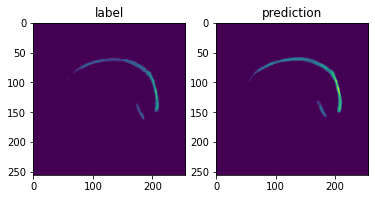

current epoch: 2 current mean dice: 0.7875
best mean dice: 0.7875 at epoch: 2
----------
epoch 3/256
epoch 3 average loss: 0.0869
----------
epoch 4/256
epoch 4 average loss: 0.0893
current epoch: 4 current mean dice: 0.7804
best mean dice: 0.7875 at epoch: 2
----------
epoch 5/256
epoch 5 average loss: 0.1090
----------
epoch 6/256
epoch 6 average loss: 0.0887
current epoch: 6 current mean dice: 0.7699
best mean dice: 0.7875 at epoch: 2
----------
epoch 7/256
epoch 7 average loss: 0.0950
----------
epoch 8/256
epoch 8 average loss: 0.0937
current epoch: 8 current mean dice: 0.7706
best mean dice: 0.7875 at epoch: 2
----------
epoch 9/256
epoch 9 average loss: 0.0907
----------
epoch 10/256
epoch 10 average loss: 0.0885
current epoch: 10 current mean dice: 0.7727
best mean dice: 0.7875 at epoch: 2
----------
epoch 11/256
epoch 11 average loss: 0.0869
----------
epoch 12/256
epoch 12 average loss: 0.0868
current epoch: 12 current mean dice: 0.7680
best mean dice: 0.7875 at epoch: 2
----

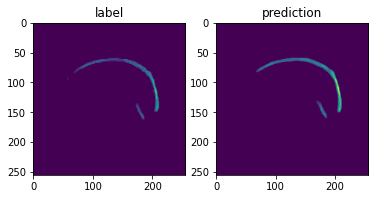

current epoch: 62 current mean dice: 0.7880
best mean dice: 0.7880 at epoch: 62
----------
epoch 63/256
epoch 63 average loss: 0.0938
----------
epoch 64/256
epoch 64 average loss: 0.0816
current epoch: 64 current mean dice: 0.7623
best mean dice: 0.7880 at epoch: 62
----------
epoch 65/256
epoch 65 average loss: 0.0793
----------
epoch 66/256
epoch 66 average loss: 0.0849
current epoch: 66 current mean dice: 0.7664
best mean dice: 0.7880 at epoch: 62
----------
epoch 67/256
epoch 67 average loss: 0.0920
----------
epoch 68/256
epoch 68 average loss: 0.0934
current epoch: 68 current mean dice: 0.7538
best mean dice: 0.7880 at epoch: 62
----------
epoch 69/256
epoch 69 average loss: 0.0847
----------
epoch 70/256
epoch 70 average loss: 0.0844
current epoch: 70 current mean dice: 0.7817
best mean dice: 0.7880 at epoch: 62
----------
epoch 71/256
epoch 71 average loss: 0.0870
----------
epoch 72/256
epoch 72 average loss: 0.0786
current epoch: 72 current mean dice: 0.7692
best mean dice: 

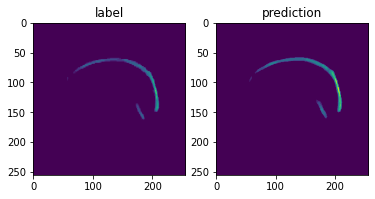

current epoch: 110 current mean dice: 0.7886
best mean dice: 0.7886 at epoch: 110
----------
epoch 111/256
epoch 111 average loss: 0.0856
----------
epoch 112/256
epoch 112 average loss: 0.0825
current epoch: 112 current mean dice: 0.7778
best mean dice: 0.7886 at epoch: 110
----------
epoch 113/256
epoch 113 average loss: 0.0817
----------
epoch 114/256
epoch 114 average loss: 0.0817
current epoch: 114 current mean dice: 0.7746
best mean dice: 0.7886 at epoch: 110
----------
epoch 115/256
epoch 115 average loss: 0.0791
----------
epoch 116/256
epoch 116 average loss: 0.0860
saved new best metric model


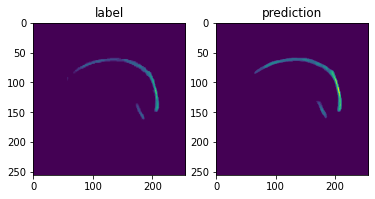

current epoch: 116 current mean dice: 0.7890
best mean dice: 0.7890 at epoch: 116
----------
epoch 117/256
epoch 117 average loss: 0.0799
----------
epoch 118/256
epoch 118 average loss: 0.0895
current epoch: 118 current mean dice: 0.7877
best mean dice: 0.7890 at epoch: 116
----------
epoch 119/256
epoch 119 average loss: 0.0842
----------
epoch 120/256
epoch 120 average loss: 0.0847
current epoch: 120 current mean dice: 0.7721
best mean dice: 0.7890 at epoch: 116
----------
epoch 121/256
epoch 121 average loss: 0.0861
----------
epoch 122/256
epoch 122 average loss: 0.0751
current epoch: 122 current mean dice: 0.7737
best mean dice: 0.7890 at epoch: 116
----------
epoch 123/256
epoch 123 average loss: 0.0903
----------
epoch 124/256
epoch 124 average loss: 0.0896
current epoch: 124 current mean dice: 0.7704
best mean dice: 0.7890 at epoch: 116
----------
epoch 125/256
epoch 125 average loss: 0.0818
----------
epoch 126/256
epoch 126 average loss: 0.0852
current epoch: 126 current mea

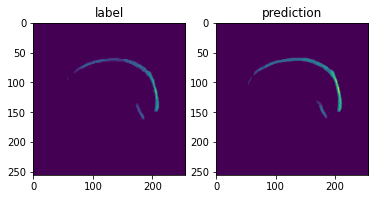

current epoch: 184 current mean dice: 0.7891
best mean dice: 0.7891 at epoch: 184
----------
epoch 185/256
epoch 185 average loss: 0.0812
----------
epoch 186/256
epoch 186 average loss: 0.0889
current epoch: 186 current mean dice: 0.7820
best mean dice: 0.7891 at epoch: 184
----------
epoch 187/256
epoch 187 average loss: 0.0834
----------
epoch 188/256
epoch 188 average loss: 0.0775
current epoch: 188 current mean dice: 0.7844
best mean dice: 0.7891 at epoch: 184
----------
epoch 189/256
epoch 189 average loss: 0.0827
----------
epoch 190/256
epoch 190 average loss: 0.0726
current epoch: 190 current mean dice: 0.7782
best mean dice: 0.7891 at epoch: 184
----------
epoch 191/256
epoch 191 average loss: 0.0793
----------
epoch 192/256
epoch 192 average loss: 0.0808
current epoch: 192 current mean dice: 0.7820
best mean dice: 0.7891 at epoch: 184
----------
epoch 193/256
epoch 193 average loss: 0.0799
----------
epoch 194/256
epoch 194 average loss: 0.0741
current epoch: 194 current mea

In [ ]:
max_epochs = 256
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = AsDiscrete(argmax=True, to_onehot=True, n_classes=2)
post_label = AsDiscrete(to_onehot=True, n_classes=2)
root_dir = path0
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            torch.cat((batch_data["image1"].to(device),batch_data["image2"].to(device)),axis=1),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if step%25 == -1:
            print(
                f"{step}/{len(train_ds) // train_loader.batch_size}, "
                f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            metric_sum = 0.0
            metric_count = 0
            for val_data in val_loader:
                val_inputs, val_labels = (
                    torch.cat((val_data["image1"].to(device),val_data["image2"].to(device)),axis=1),
                    val_data["label"].to(device),
                )
                sw_batch_size = 1
                val_outputs = model(val_inputs)
#                val_outputs = post_pred(val_outputs)
                val_outputs = torch.unsqueeze(torch.argmax(val_outputs,dim=1),dim=0)
                #val_labels = post_label(val_labels)
                value = compute_meandice(
                    y_pred=val_outputs,
                    y=val_labels,
                    include_background=False,
                )

                metric_count += len(value)
                metric_sum += value.sum().item()
            metric = metric_sum / metric_count
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model_yh_.pth"))
                print("saved new best metric model")                
                plt.subplot(1,2,1)
                plt.title('label')
                plt.imshow(torch.sum(val_labels[0,0],axis=2).cpu())
                plt.subplot(1,2,2)
                plt.title('prediction')
                plt.imshow(torch.sum(val_outputs[0,0],axis=2).cpu())
                plt.show()
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

In [ ]:
val_outputs = model(val_inputs)
val_outputs.shape

In [ ]:
plt.imshow(val_outputs[0,1,:,:,32].cpu().detach().numpy())